### Understanding convolutions

http://setosa.io/ev/image-kernels/

In [1]:
from skimage.data import camera, chelsea
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np

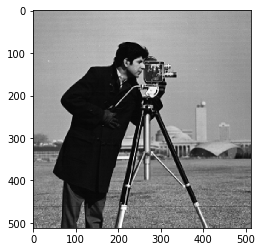

In [2]:
camerman = camera()
plt.imshow(camerman, cmap='gray')

In [3]:
t_cameraman = torch.from_numpy(camerman).float()
t_cameraman = t_cameraman.unsqueeze(0) # ads dimension at the begining
t_cameraman = t_cameraman.unsqueeze(0)
t_cameraman.shape

torch.Size([1, 1, 512, 512])

In [4]:
edge_filter  = torch.Tensor([[[[-1,-1,-1],
                               [-1, 8, -1], 
                               [-1,-1, -1]]
                             ]])
#output = F.relu(F.conv2d(t_cameraman, edge_filter, padding=1))
output = F.conv2d(t_cameraman, edge_filter, padding=1)

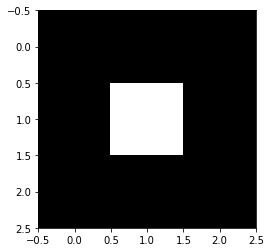

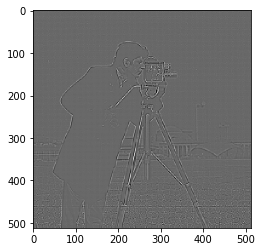

In [5]:
plt.figure()
plt.imshow(edge_filter.numpy()[0][0], cmap='gray')
plt.figure()
plt.imshow(output[0][0],cmap='gray')

In [6]:
left_sobel  = torch.Tensor([[[[1,0,-1],
                              [1,0, -1], 
                              [1,0 , -1]]]]) 


output = F.conv2d(t_cameraman, left_sobel, padding=1)
output

tensor([[[[-314.,   -7.,   -3.,  ...,   -2.,    0.,  304.],
          [-471.,   -5.,   -2.,  ...,   -1.,    0.,  456.],
          [-471.,    5.,    3.,  ...,    3.,    1.,  456.],
          ...,
          [-369.,  -24.,  -11.,  ...,   56.,   34.,  338.],
          [-369.,  -15.,   -9.,  ...,   51.,   30.,  339.],
          [-246.,  -10.,   -6.,  ...,   34.,   20.,  226.]]]])

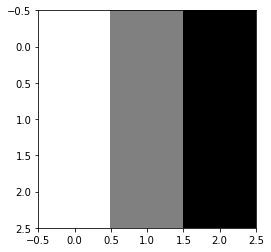

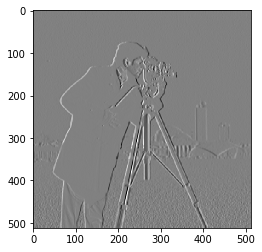

In [7]:
plt.figure()
plt.imshow(left_sobel.numpy()[0][0], cmap='gray')
plt.figure()
plt.imshow(output[0][0].numpy(),cmap='gray')

# RGB convolutions
![](rgb.gif)

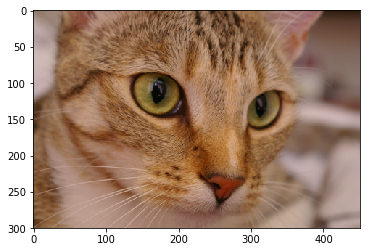

In [8]:
ch = chelsea()
plt.imshow(ch)

In [9]:
# Pytorch expects channels first 

t_ch = torch.from_numpy(ch).float()
t_ch = t_ch.unsqueeze(0)
t_ch = t_ch.permute([0,3,1,2])  #in numpy swappping from channels last to channels first can be done with moveaxis
tch = t_ch / 255

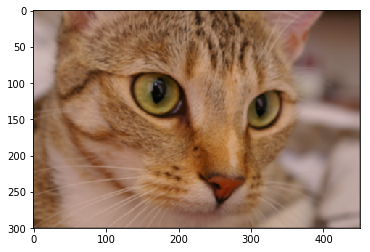

In [10]:
# since this is a color image we need to have a filter for each color-channel thus we repeat the kernel 3 times

blur  = torch.Tensor([[[[1/16, 1/8,1/16],
                              [1/8, 1/4, 1/8], 
                              [1/16, 1/8,1/16]]]])
# left_sobel = left_sobel.repeat((1, 3, 1, 1))

output_r = F.conv2d(t_ch[:, 0:1, :, :], blur, padding=1) # Selector vs Slicing: One preserves dimensions, one not
output_g = F.conv2d(t_ch[:, 1:2, :, :], blur, padding=1) # Selector vs Slicing: One preserves dimensions, one not
output_b = F.conv2d(t_ch[:, 2:3, :, :], blur, padding=1) # Selector vs Slicing: One preserves dimensions, one not

image = torch.cat([output_r, output_g, output_b], dim=1)
image = np.moveaxis(image.numpy()[0], 0, 2).astype('uint8')

plt.imshow(image)

# Tips and tricks

- pytorch comes with handy utility functions like ones_like, ones, zeroes_like, etc. They come handy quite often

# Exercise 1

1. Create different sizes of bluring kernels. For instance (3x3, 7x7, 9x9) apply them on the cameraman picture  and compare the results side by side.

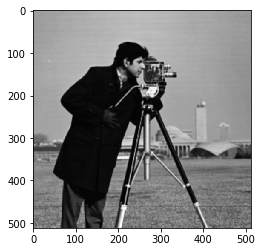

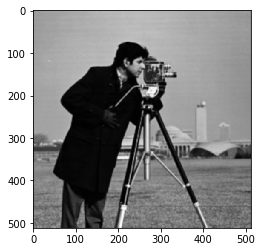

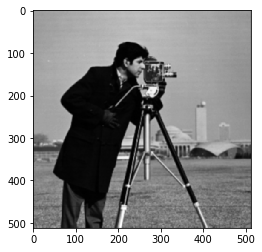

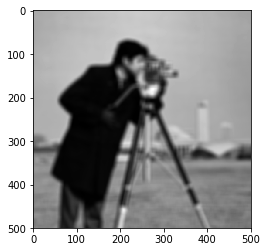

In [11]:
blur_3x3  = torch.Tensor([[[[ 1/16., 2/16., 1/16.],
                            [ 2/16., 4/16., 2/16.], 
                            [ 1/16., 2/16., 1/16.]
                           ]]]) 

blur_5x5  = torch.Tensor([[[[  1/256.,  4/256.,  6/256.,  4/256.,  1/256.],
                            [  4/256., 16/256., 24/256., 16/256.,  4/256.], 
                            [  6/256., 24/256., 36/256., 24/256.,  6/256.],
                            [  4/256., 16/256., 24/256., 16/256.,  4/256.],
                            [  1/256.,  4/256.,  6/256.,  4/256.,  1/256.]
                           ]]])

blur_9x9 = torch.Tensor([[[[0, 0.000001,0.000014,0.000055,0.000088,0.000055,0.000014,0.000001,0],
[0.000001,0.000036,0.000362,0.001445,0.002289,0.001445,0.000362,0.000036,0.000001],
[0.000014,0.000362,0.003672,0.014648,0.023205,0.014648,0.003672,0.000362,0.000014],
[0.000055,0.001445,0.014648,0.058434,0.092566,0.058434,0.014648,0.001445,0.000055],
[0.000088,0.002289,0.023205,0.092566,0.146634,0.092566,0.023205,0.002289,0.000088],
[0.000055,0.001445,0.014648,0.058434,0.092566,0.058434,0.014648,0.001445,0.000055],
[0.000014,0.000362,0.003672,0.014648,0.023205,0.014648,0.003672,0.000362,0.000014],
[0.000001,0.000036,0.000362,0.001445,0.002289,0.001445,0.000362,0.000036,0.000001],
[0,0.000001,0.000014,0.000055,0.000088,0.000055,0.000014,0.000001,0]
                        ]]])

import scipy.stats as st
nsig = 1 # standard deviation
kernlen = 13 # kernel width/height
interval = (2*nsig+1.)/(kernlen)
x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
kern1d = np.diff(st.norm.cdf(x))
kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
kernel = kernel_raw/kernel_raw.sum()
kernel = torch.from_numpy(kernel).unsqueeze(0).unsqueeze(0).float()

output_3x3 = F.conv2d(t_cameraman, blur_3x3, padding=1)
plt.figure()
plt.imshow(output_3x3[0][0],cmap='gray')

output_5x5 = F.conv2d(t_cameraman, blur_5x5, padding=2)
plt.figure()
plt.imshow(output_5x5[0][0],cmap='gray')

output_9x9 = F.conv2d(t_cameraman, blur_9x9, padding=4)
plt.figure()
plt.imshow(output_9x9[0][0],cmap='gray')

output_kxk = F.conv2d(t_cameraman, kernel, padding=0)
plt.figure()
plt.imshow(output_kxk[0][0],cmap='gray')

In [12]:
from torch.nn import Conv2d, MaxPool2d
in_features = torch.randn((1,3,512,512))
conv = Conv2d(3,1,3)
pool = MaxPool2d(2, stride = 2)

print(in_features.shape)
out = conv(in_features)
print(out.shape)
out = pool(out)
print(out.shape)
print(conv.weight.shape)

torch.Size([1, 3, 512, 512])
torch.Size([1, 1, 510, 510])
torch.Size([1, 1, 255, 255])
torch.Size([1, 3, 3, 3])
